## Imports

In [7]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import zipfile
import os
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (Reshape, LeakyReLU, Dropout, Conv2DTranspose, Add, Conv2D, MaxPool2D, Dense,
                                     Flatten, InputLayer, BatchNormalization, Input)
from tensorflow.keras.optimizers import Adam

## Data

### Download Data

In [5]:
!kaggle datasets download -d jessicali9530/celeba-dataset


  0%|          | 0.00/1.33G [00:00<?, ?B/s]
  0%|          | 1.00M/1.33G [00:01<33:42, 705kB/s]
  0%|          | 2.00M/1.33G [00:01<17:12, 1.38MB/s]
  0%|          | 3.00M/1.33G [00:01<10:23, 2.29MB/s]
  0%|          | 4.00M/1.33G [00:01<07:13, 3.29MB/s]
  0%|          | 6.00M/1.33G [00:02<04:08, 5.72MB/s]
  1%|          | 8.00M/1.33G [00:02<02:56, 8.04MB/s]
  1%|          | 10.0M/1.33G [00:02<02:17, 10.3MB/s]
  1%|          | 12.0M/1.33G [00:02<02:03, 11.4MB/s]
  1%|          | 15.0M/1.33G [00:02<01:52, 12.6MB/s]
  1%|▏         | 18.0M/1.33G [00:02<01:38, 14.3MB/s]
  2%|▏         | 21.0M/1.33G [00:02<01:23, 16.9MB/s]
  2%|▏         | 23.0M/1.33G [00:03<01:23, 16.9MB/s]
  2%|▏         | 25.0M/1.33G [00:03<01:21, 17.3MB/s]
  2%|▏         | 27.0M/1.33G [00:03<01:22, 16.9MB/s]
  2%|▏         | 29.0M/1.33G [00:03<01:25, 16.4MB/s]
  2%|▏         | 32.0M/1.33G [00:03<01:22, 17.0MB/s]
  3%|▎         | 35.0M/1.33G [00:03<01:17, 18.0MB/s]
  3%|▎         | 37.0M/1.33G [00:03<01:19, 17.6MB/s]
  

Dataset URL: https://www.kaggle.com/datasets/jessicali9530/celeba-dataset
License(s): other



In [6]:
# !unzip celeba-dataset.zip -d dataset/

'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [8]:
zip_file = "celeba-dataset.zip"
destination_folder = "dataset/"

with zipfile.ZipFile(zip_file) as zip_ref:
    zip_ref.extractall(destination_folder)

### Prepare Data

In [9]:
BATCH_SIZE = 128
IM_SHAPE = (64,64,3)
LEARNING_RATE = 2e-4
LATENT_DIM = 100
EPOCHS = 50

In [13]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "dataset/img_align_celeba/img_align_celeba", label_mode = None, image_size=(IM_SHAPE[0], IM_SHAPE[1]), batch_size = BATCH_SIZE
)

Found 202599 files belonging to 1 classes.


In [14]:
dataset

<BatchDataset shapes: (None, 64, 64, 3), types: tf.float32>

In [19]:
def preprocess(image):
    return tf.cast(image, tf.float32)/127.5-1.0     ##normalizing from -1 to 1

In [20]:
train_dataset = (
    dataset
    .map(preprocess)
    .unbatch()
    .shuffle(buffer_size = 1024, reshuffle_each_iteration = True)
    .batch(BATCH_SIZE, drop_remainder = True)
    .prefetch(tf.data.AUTOTUNE)
)

In [22]:
for d in train_dataset.take(1):
    print(d.shape)

(128, 64, 64, 3)


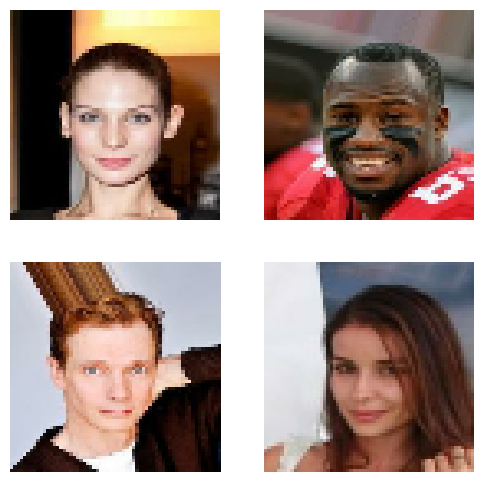

In [24]:
plt.figure(figsize=(6,6))
k=0
n=4
for i in range(n):
    ax = plt.subplot(2,2,k+1)
    plt.imshow((d[i]+1)/2)
    plt.axis('off')
    k+=1

## Modelling

In [25]:
generator = tf.keras.Sequential([
    Input(shape=(LATENT_DIM)),
    Dense(4*4*LATENT_DIM),
    Reshape((4,4,LATENT_DIM)),

    Conv2DTranspose(512, kernel_size = 4, strides=2, padding='same'),
    BatchNormalization(),
    LeakyReLU(0.2),

    Conv2DTranspose(256, kernel_size = 4, strides=2, padding='same'),
    BatchNormalization(),
    LeakyReLU(0.2),

    Conv2DTranspose(128, kernel_size = 4, strides=2, padding='same'),
    BatchNormalization(),
    LeakyReLU(0.2),

    Conv2DTranspose(3, kernel_size = 4, strides=2,activation=tf.keras.activations.tanh, padding='same'),
], name='generator')

In [26]:
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1600)              161600    
                                                                 
 reshape (Reshape)           (None, 4, 4, 100)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 512)        819712    
 nspose)                                                         
                                                                 
 batch_normalization (BatchN  (None, 8, 8, 512)        2048      
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 8, 8, 512)         0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 16, 16, 256)      20

In [30]:
discriminator = tf.keras.Sequential([
    Input(shape=(IM_SHAPE[0], IM_SHAPE[1],3)),

    Conv2D(64, kernel_size=4, strides=2,padding='same'),
    LeakyReLU(0.2),

    Conv2D(128, kernel_size=4, strides=2,padding='same'),
    BatchNormalization(),
    LeakyReLU(0.2),

    Conv2D(256, kernel_size=4, strides=2,padding='same'),
    BatchNormalization(),
    LeakyReLU(0.2),

    Conv2D(1, kernel_size=4, strides=2, padding='same'),

    Flatten(),
    Dense(1, activation='sigmoid'),
], name='discriminator')

In [31]:
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 32, 32, 64)        3136      
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 batch_normalization_7 (Batc  (None, 16, 16, 128)      512       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 16, 16, 128)       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 8, 8, 256)         524544    
                                                     

In [32]:
class ShowImage(tf.keras.callbacks.Callback):
    def __init__(self, latent_dim=100):
        self.latent_dim = latent_dim
    
    def on_epoch_end(self, epoch, logs=None):
        n=6
        k=0
        out = self.model.generator(tf.random.normal(shape=(36, self.latent_dim)))
        plt.figure(figsize=(16,16))
        for i in range(n):
            for j in range(n):
                ax = plt.subplot(n,n,k+1)
                # plt.imshow((out[k]+1)/2)
                # plt.axis('off')
                k+=1
        plt.savefig("generated/gen_images_epoch_{}.png".format(epoch+1))

In [37]:
class GAN(tf.keras.Model):
  def __init__(self,discriminator,generator):
    super(GAN,self).__init__()
    self.discriminator=discriminator
    self.generator=generator

  def compile(self,d_optimizer,g_optimizer,loss_fn):
    super(GAN,self).compile()
    self.d_optimizer=d_optimizer
    self.g_optimizer=g_optimizer
    self.loss_fn=loss_fn
    self.d_loss_metric=tf.keras.metrics.Mean(name='d_loss')
    self.g_loss_metric=tf.keras.metrics.Mean(name='g_loss')
    
  @property
  def metrics(self):
    return [self.d_loss_metric,self.g_loss_metric]
  
  def train_step(self,real_images):
    batch_size=tf.shape(real_images)[0]

    ######## Discriminator
    random_noise=tf.random.normal(shape=(batch_size,LATENT_DIM))
    fake_images=self.generator(random_noise)

    real_labels=tf.ones((batch_size,1))+0.25*tf.random.uniform((batch_size,1),minval=-1,maxval=1)
    fake_labels=tf.zeros((batch_size,1))+0.25*tf.random.uniform((batch_size,1),)

    with tf.GradientTape() as recorder:
      real_predictions=self.discriminator(real_images)
      d_loss_real=self.loss_fn(real_labels,real_predictions)

      fake_predictions=self.discriminator(fake_images)
      d_loss_fake=self.loss_fn(fake_labels,fake_predictions)

      d_loss=d_loss_real+d_loss_fake
      
    partial_derivatives = recorder.gradient(d_loss,self.discriminator.trainable_weights)
    self.d_optimizer.apply_gradients(zip(partial_derivatives, self.discriminator.trainable_weights))

    ############# Generator
    random_noise=tf.random.normal(shape=(batch_size,LATENT_DIM))
    flipped_fake_labels=tf.ones((batch_size,1))

    with tf.GradientTape() as recorder:

      fake_predictions=self.discriminator(self.generator(random_noise))
      g_loss=self.loss_fn(flipped_fake_labels,fake_predictions)
      
    partial_derivatives = recorder.gradient(g_loss,self.generator.trainable_weights)
    self.g_optimizer.apply_gradients(zip(partial_derivatives, self.generator.trainable_weights))

    self.d_loss_metric.update_state(d_loss)
    self.g_loss_metric.update_state(g_loss)
    
    return {'d_loss':self.d_loss_metric.result(),
            'g_loss':self.g_loss_metric.result()}

In [38]:
gan = GAN(discriminator, generator)
gan.compile(
    d_optimizer=Adam(learning_rate=LEARNING_RATE, beta_1=0.5),
    g_optimizer=Adam(learning_rate=LEARNING_RATE, beta_1=0.5),
    loss_fn=tf.keras.losses.BinaryCrossentropy() 
)

In [1]:
EPOCHS=100
history = gan.fit(train_dataset, epochs=EPOCHS, callbacks=[ShowImage(LATENT_DIM)])


In [ ]:
plt.plot(history.history['d_loss'])
plt.plot(history.history['g_loss'])
plt.title('GAN Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['d_loss', 'g_loss'], loc='upper left')
plt.show()